**MACHINE LEARNING HOMEWORK 1 - Adil Mert Ergörün**

Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, mean_absolute_error, auc
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold

Fetching the needed datasets and clearing up the dataset.

In [2]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# fetch breast cancer dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

bc_features = breast_cancer_wisconsin_diagnostic.data.features
bc_targets = breast_cancer_wisconsin_diagnostic.data.targets

# map the string values to int values, M -> 1 and B -> 0
bc_targets_mapped = bc_targets.replace({'M': 1, 'B': 0})

# fetch bike sharing dataset
bike_sharing = fetch_ucirepo(id=275)

bs_features = bike_sharing.data.features
bs_targets = bike_sharing.data.targets

# month and year data already exists, we only have to seperate day data
year = pd.to_datetime(bs_features['dteday'])
bs_features['dy'] = year.dt.day
bs_features = bs_features.drop(columns=['dteday'])

<ipython-input-2-6e2864b3333e>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bc_targets_mapped = bc_targets.replace({'M': 1, 'B': 0})
<ipython-input-2-6e2864b3333e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_features['dy'] = year.dt.day


**PART 1 - CODE**

KNN classifier and euclidean distance function, and a function to visualize our confusion matrix

In [3]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def knn_classifier(X_train, y_train, X_test, k=3):
    predictions = []

    # Convert DataFrames to numpy arrays
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_test = X_test.to_numpy()

    for test_point in X_test:
        # Calculate distance from the test point to all training points
        distances = [euclidean_distance(test_point, train_point) for train_point in X_train]

        # Get the indices of the k-nearest neighbors
        nearest_indices = np.argsort(distances)[:k]

        # Get the labels of the k-nearest neighbors
        nearest_labels = y_train[nearest_indices]
        # Change multi-dimensional array to 1d array
        nearest_labels = nearest_labels.ravel().astype(int)

        # Predict the label by majority voting
        predicted_label = np.bincount(nearest_labels).argmax()

        predictions.append(predicted_label)

    return np.array(predictions)

def k_fold_cross_validation_classification(X, y, num_folds=6, k=3):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    accuracies = []
    confusion_matrices = []

    for train_index, test_index in kf.split(X):
        # Allocate train and test data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Get the accuarcy of the current split
        prediction = knn_classifier(X_train, y_train, X_test, k)
        accuracy = accuracy_score(y_test, prediction)
        accuracies.append(accuracy)

        # Get the confusion matrix of the current split
        cm = confusion_matrix(y_test, prediction)
        confusion_matrices.append(cm)

    total_cm = np.sum(confusion_matrices, axis=0)
    return np.mean(accuracies), total_cm

# A basic function for plotting the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Execution Time: 1.9438 seconds
Accuracy: 0.9191116088092572
Confusion Matrix:


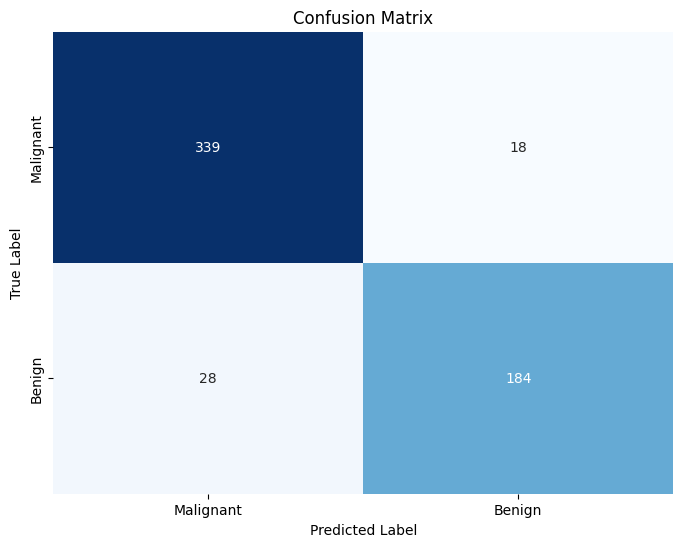

In [4]:
start_time = time.time()

avg_accuracy, cm = k_fold_cross_validation_classification(bc_features, bc_targets_mapped)

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution Time: {execution_time:.4f} seconds")
print("Accuracy:", avg_accuracy)
print("Confusion Matrix:")

plot_confusion_matrix(cm, ['Malignant', 'Benign'])

**PART 1 - RESULTS**

*   Execution Time: 1.9543 seconds

*   Accuracy: 0.9191116088092572

*   Confusion Matrix:

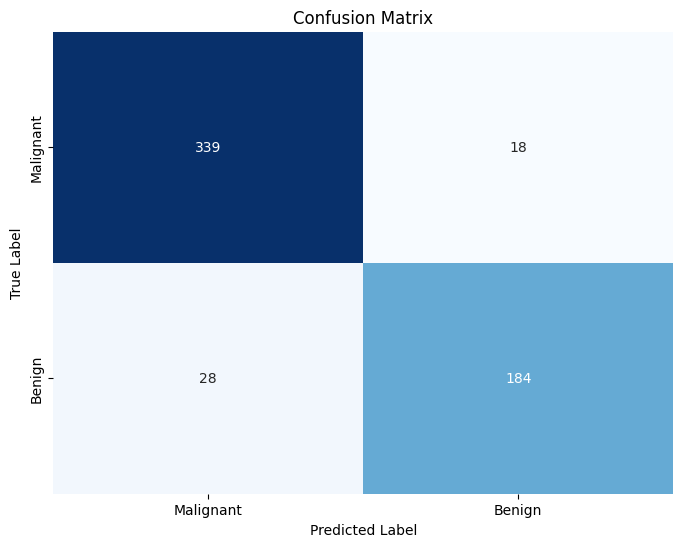

**PART 1 - COMMENTS**

91% accuracy is a strong result, indicating that the KNN classifier performed well on the breast cancer dataset. 1.94 second execution time seems okay, but we have a small database and for larger ones this might become an issue.

---
As for the confusion matrix, we can see that model predicted both classes equally well, with a small tendency to predict Benign values as Malignant, but not so much to draw any conclusions from.


**PART 2 - CODE**

In [5]:
def knn_regressor(X_train, y_train, X_test, k = 3):
    predictions = []

    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = y_train.to_numpy().ravel()

    for test_point in X_test:
        distances = np.sum(np.abs(X_train - test_point), axis=1)

        k_indices = np.argsort(distances)[:k]
        k_labels = y_train[k_indices]

        predictions.append(np.mean(k_labels))

    return np.array(predictions)

def k_fold_cross_validation_regression(X, y, num_folds=6, k=3):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    maes = []

    for train_index, test_index in kf.split(X):
        # Allocate train and test data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        predictions = knn_regressor(X_train, y_train, X_test, k)
        mae = mean_absolute_error(y_test, predictions)
        maes.append(mae)

    return np.mean(maes)

In [6]:
start_time = time.time()

mae = k_fold_cross_validation_regression(bs_features, bs_targets)

end_time = time.time()
execution_time = end_time - start_time

print("Mean Absolute Error:", mae)
print("Execution time:", execution_time, "seconds")

Mean Absolute Error: 51.830239477959566
Execution time: 20.911980390548706 seconds


**PART 2 - RESULTS**

Mean Absolute Error: 51.830239477959566

---

Execution time: 20.911980390548706 seconds

**PART 2 - COMMENTS**

51.8 mean absolute error is relatively high, indicating that the model struggles with this dataset. 21s execution is also expected because of the larger dataset and continious calculations.

---

Overall, we can conclude that knn is not the best choice for this regression task. It may perform better with some feature scaling or hyperparameter tuning.


**PART 3 - CODE**

In [18]:
def svm_classifier(X, y, k=6):
    sk_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    conf_matrices = []
    fprs = []
    tprs = []
    aucs = []
    threshold_list = []

    X = X.to_numpy()
    y = y.to_numpy().ravel()

    svm = SVC(kernel="linear", probability=True)

    for train_index, test_index in sk_fold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        svm.fit(X_train, y_train)

        y_prob = svm.predict_proba(X_test)[:, 1]  # Get probabilities for positive(Malignant) class

        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        auc_score = auc(fpr, tpr)
        aucs.append(auc_score)
        threshold_list.append(thresholds)
        fprs.append(fpr)
        tprs.append(tpr)

        # Find best threshold using Fawvett's method
        opt_idx = np.argmax(tpr - fpr)
        opt_threshold = thresholds[opt_idx]

        predictions = (y_prob >= opt_threshold).astype(int)
        acc = accuracy_score(y_test, predictions)
        conf_matrix = confusion_matrix(y_test, predictions)

        accuracies.append(acc)
        conf_matrices.append(conf_matrix)

    mean_acc = np.mean(accuracies)
    total_cm = np.sum(conf_matrices, axis=0)
    return mean_acc, total_cm, aucs, fprs, tprs, threshold_list

def plot_roc_curve(fprs, tprs, aucs):
    plt.figure(figsize=(10, 8))

    for i in range(len(fprs)):
        plt.plot(fprs[i], tprs[i], label=f"Fold {i + 1}, AUC = {aucs[i]:.2f}")

    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC=0.5)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

Mean Accuracy: 0.9578760731616275
Execution time: 37.9427 seconds
Combined Confusion Matrix:


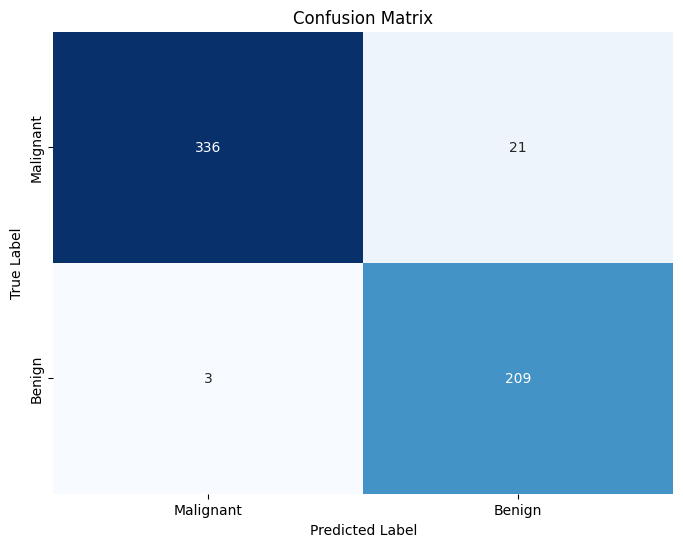


Mean AUC: 0.9893789794637252


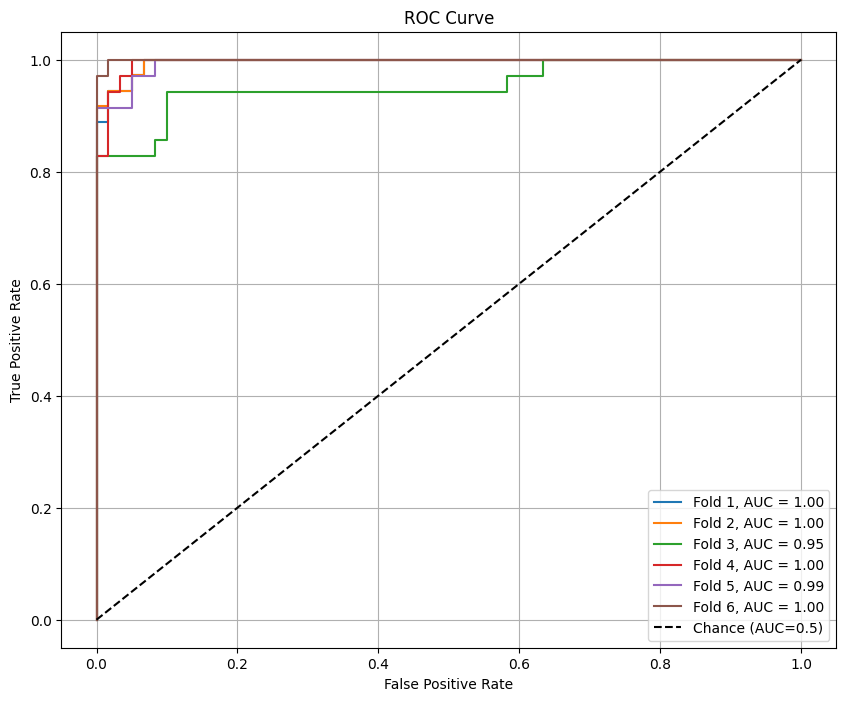

In [19]:
start_time = time.time()
acc, conf_matrix, aucs, fprs, tprs, threshold_list = svm_classifier(bc_features, bc_targets_mapped)

end_time = time.time()
execution_time = end_time - start_time

print("Mean Accuracy:", acc)
print(f"Execution time: {execution_time:.4f} seconds")
print("Combined Confusion Matrix:")
plot_confusion_matrix(conf_matrix, ['Malignant', 'Benign'])
print()

print("Mean AUC:", np.mean(aucs))
plot_roc_curve(fprs, tprs, aucs)


**PART 3 - RESULTS**

Mean Accuracy: 0.9578760731616275


---


Execution time: 37.9427 seconds



---

Combined Confusion Matrix:

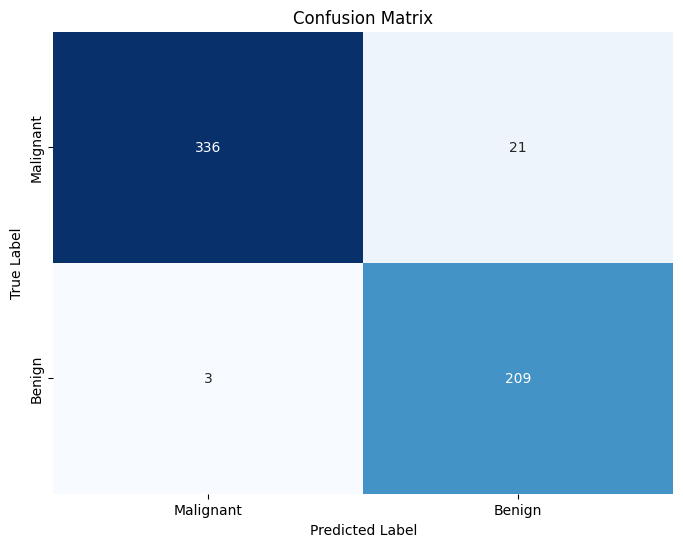

---

Mean AUC: 0.9893789794637252

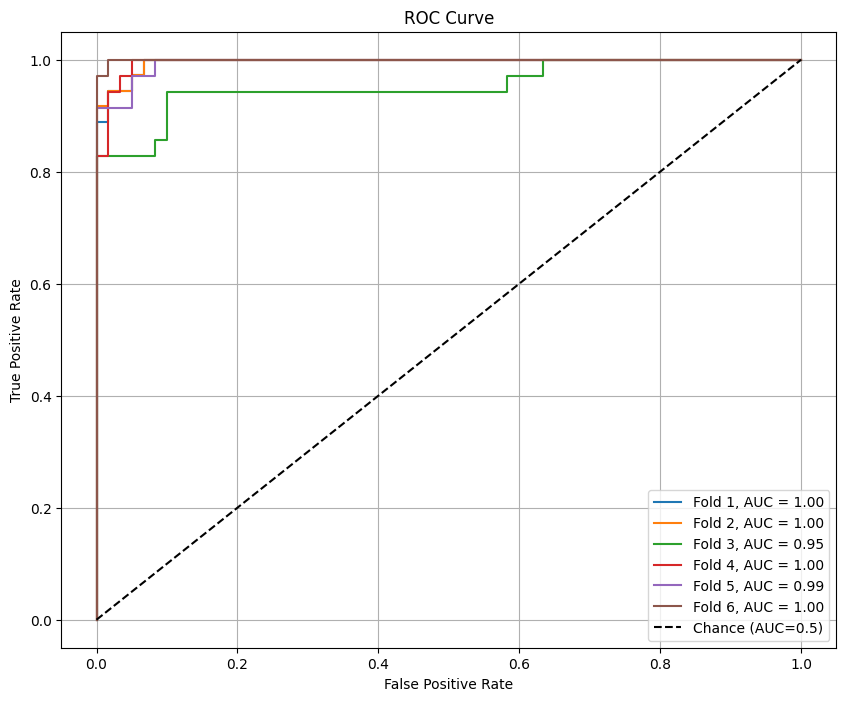

**PART 3 - COMMENTS**

96% accuracy is really impressive, even higher than knn, showing SVM's effectiveness in class seperation. 37s exection time is uncharacteristically high, which is probably caused by the calculations about finding the best threshold for the ROC curves and calculating the accuracies from it.


---

AUC of 0.98 is a strong value, indicating that the classifier makes confident prediction with good seperation between classes.



---

As for the confusion matrix, this time model has a slight tendency to label Malignant values as Benign, but again not much to draw any conclusions from.

**PART 4 - CODE**

In [11]:
def svm_regressor(X, y, k=6):
    k_fold = KFold(n_splits=k, shuffle=True, random_state=42)
    maes = []

    svm = SVR(kernel="linear")

    X = X.to_numpy()
    y = y.to_numpy().ravel()
    for train_index, test_index in k_fold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        svm.fit(X_train, y_train)

        predictions = svm.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        maes.append(mae)

    return np.mean(maes)

In [12]:
start_time = time.time()

mae = svm_regressor(bs_features, bs_targets)

end_time = time.time()
execution_time = end_time - start_time

print("Mean Absolute Error:", mae)
print(f"Execution time: {execution_time:.4f} seconds.")

Mean Absolute Error: 101.44351191210087
Execution time: 96.1544 seconds.


**PART 4 - RESULTS**

Mean Absolute Error: 101.44351191210087



---


Execution time: 96.1544 seconds.

**PART 4 - COMMENTS**

101.4 mean absolute error is significantly higher compared to KNN and Desicion Tree algorithm models, which suggests that SVM regression is not well-suited for this dataset.



---

96 second execution time. Again, the worst result among all of the models, both because of the larger dataset and complex calculations required.



---

Overall, this model is not a good fit for the problem at hand. Some non-linear kernel or feature tuning may improve results.

**PART 5 - CODE**

In [13]:
# We use max_depth and ccp_alpha variables to control prunning strategies
def dt_classifier(X, y, k=6, max_depth=None, ccp_alpha=0.0):
    k_fold = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []

    # We keep the latest model to extract the rules
    latest_model = None

    for train_index, test_index in k_fold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        dt = DecisionTreeClassifier(max_depth=max_depth, ccp_alpha=ccp_alpha, random_state=42)
        dt.fit(X_train, y_train)

        predictions = dt.predict(X_test)
        acc = accuracy_score(y_test, predictions)
        accuracies.append(acc)

        latest_model = dt

    return np.mean(accuracies), latest_model

# Write your own!!!
def extract_rules(dt, feature_names):
    return export_text(dt, feature_names=feature_names)

In [14]:
# Pre-pruning
start_time = time.time()
accuracy_pre_pruned, pre_prunned_dt = dt_classifier(bc_features, bc_targets_mapped, max_depth=3)
print(f"Pre-pruned DT (max_depth=3) Accuracy: {accuracy_pre_pruned:.4f}")
print()

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds.")
print()

# Post-pruning
start_time = time.time()
accuracy_post_pruned, post_prunned_dt = dt_classifier(bc_features, bc_targets_mapped, ccp_alpha=0.01)
print(f"Post-pruned DT (ccp_alpha=0.01) Accuracy: {accuracy_post_pruned:.4f}")
print()

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds.")
print()

# Extracting and printing the pre prunned dt rules
rules = extract_rules(pre_prunned_dt, bc_features.columns)
print("Pre-pruned DT Rules:")
print(rules)

Pre-pruned DT (max_depth=3) Accuracy: 0.9385

Execution time: 0.0909 seconds.

Post-pruned DT (ccp_alpha=0.01) Accuracy: 0.9491

Execution time: 0.1050 seconds.

Pre-pruned DT Rules:
|--- area3 <= 884.55
|   |--- concave_points3 <= 0.16
|   |   |--- concave_points3 <= 0.13
|   |   |   |--- class: 0
|   |   |--- concave_points3 >  0.13
|   |   |   |--- class: 0
|   |--- concave_points3 >  0.16
|   |   |--- texture3 <= 23.47
|   |   |   |--- class: 0
|   |   |--- texture3 >  23.47
|   |   |   |--- class: 1
|--- area3 >  884.55
|   |--- concavity1 <= 0.07
|   |   |--- texture1 <= 19.54
|   |   |   |--- class: 0
|   |   |--- texture1 >  19.54
|   |   |   |--- class: 1
|   |--- concavity1 >  0.07
|   |   |--- class: 1



**PART 5 - RESULTS**

Pre-pruned DT (max_depth=3) Accuracy: 0.9385

Execution time: 0.0909 seconds.

Post-pruned DT (ccp_alpha=0.01) Accuracy: 0.9491

Execution time: 0.1050 seconds.

Pre-pruned DT Rules:

|--- area3 <= 884.55

|   |--- concave_points3 <= 0.16

|   |   |--- concave_points3 <= 0.13

|   |   |   |--- class: 0

|   |   |--- concave_points3 >  0.13

|   |   |   |--- class: 0

|   |--- concave_points3 >  0.16

|   |   |--- texture3 <= 23.47

|   |   |   |--- class: 0

|   |   |--- texture3 >  23.47

|   |   |   |--- class: 1

|--- area3 >  884.55

|   |--- concavity1 <= 0.07

|   |   |--- texture1 <= 19.54

|   |   |   |--- class: 0

|   |   |--- texture1 >  19.54

|   |   |   |--- class: 1

|   |--- concavity1 >  0.07

|   |   |--- class: 1


**PART 5 - COMMENTS**

Firstly I will explain what did I use to achieve different prunning strategies.

---

To achieve pre prunning I used max_depth=3 which:

*   Limits the tree to a maximum depth of 3
*   Prevents tree from growing too deep, reducing overfitting

---
To achieve post_prunning I used ccp_alpha=0.01 which:

*   Applies cost complexity pruning after growing the full tree.
*   Removes branches that contribute little to reducing impurity.
---
I used the max_depth=3 and ccp_alpha=0.01 values, because they are moderate values for their respective strategies. There were no parameter tuning involved.


As to the results, both of the strategies performed fairly well:

*   Pre-pruned DT (max_depth=3) Accuracy: 0.9350 (%93)
*   Execution time: 0.0646 seconds.

*   Post-pruned DT (ccp_alpha=0.01) Accuracy: 0.9508 (%95)
*   Execution time: 0.0790 seconds.

Post prunned tree performed a little better but took a little longer to run, but not so much to draw any conclusions from.



---

Overall, we can conclude that this model is a good fit for our dataset.

**PART 6 - CODE**

In [15]:
def dt_regressor(X, y, k=6, max_depth=None, ccp_alpha=0.0):
    k_fold = KFold(n_splits=k, shuffle=True, random_state=42)
    maes = []

    # We keep the latest model to extract the rules
    latest_model = None

    for train_index, test_index in k_fold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        dt = DecisionTreeRegressor(max_depth=max_depth, ccp_alpha=ccp_alpha, random_state=42)
        dt.fit(X_train, y_train)

        predictions = dt.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        maes.append(mae)

        latest_model = dt

    return np.mean(maes), latest_model

In [16]:
start_time = time.time()
mae, dt_regressor_model = dt_regressor(bs_features, bs_targets, max_depth=10)
print(f"Mean Absolute Error: {mae:.4f}")

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds.")
print()

Mean Absolute Error: 36.3281
Execution time: 0.3699 seconds.



**PART 6 - RESULTS**

Mean Absolute Error: 36.3281

Execution time: 0.3699 seconds.

In [17]:
# Printing the rule set of the dt model
rules = extract_rules(dt_regressor_model, bs_features.columns)
print("DT Rules:")
print(rules)

DT Rules:
|--- hr <= 6.50
|   |--- hr <= 5.50
|   |   |--- hr <= 1.50
|   |   |   |--- workingday <= 0.50
|   |   |   |   |--- temp <= 0.49
|   |   |   |   |   |--- season <= 1.50
|   |   |   |   |   |   |--- yr <= 0.50
|   |   |   |   |   |   |   |--- atemp <= 0.23
|   |   |   |   |   |   |   |   |--- mnth <= 7.50
|   |   |   |   |   |   |   |   |   |--- hum <= 0.61
|   |   |   |   |   |   |   |   |   |   |--- value: [18.29]
|   |   |   |   |   |   |   |   |   |--- hum >  0.61
|   |   |   |   |   |   |   |   |   |   |--- value: [28.71]
|   |   |   |   |   |   |   |   |--- mnth >  7.50
|   |   |   |   |   |   |   |   |   |--- temp <= 0.23
|   |   |   |   |   |   |   |   |   |   |--- value: [4.00]
|   |   |   |   |   |   |   |   |   |--- temp >  0.23
|   |   |   |   |   |   |   |   |   |   |--- value: [6.00]
|   |   |   |   |   |   |   |--- atemp >  0.23
|   |   |   |   |   |   |   |   |--- dy <= 5.50
|   |   |   |   |   |   |   |   |   |--- atemp <= 0.27
|   |   |   |   |   |   |   |  

**PART 6 - COMMENTS**

From the test I did, the values I got:

*   Mean Absolute Error: 36.4230
*   Execution time: 0.5274 seconds.

Which is the best performing algorithm so far between our regressor models, both in terms of mean absolute error and execution time. I used max_depth=10 just in case to prevent overfitting. The models I trained without depth limit weren't performing better but they took much longer to train, which makes sense.


---

Execution time of 0.5 seconds is extremely fast, especially among the other regression models. Making it clearly the most efficient regression model.



---

Overall, we can conclude that Desicion Tree provides the best balance of accuracy and speed.